In [86]:
from DataVisualisation import DataVisualisation
import ParametricalIdentification as pi
import pandas as pd
import numpy as np
import pandas as pd




In [87]:
import numpy as np

def numerical_derivative(func, x, h=1e-5):
    """
    Function to calculate derivative using finite difference method.

    Parameters:
    func (callable): Function to find derivative for.
    x (float or np.ndarray): Point(s) to calculate derivative at.
    h (float): Step for finite differences (default 1e-5).

    Returns:
    derivative: Derivative of function at point(s) x.
    """
    return (func(x + h) - func(x - h)) / (2 * h)



### Download data

In [88]:
# download data
import yfinance as yf
from DataPreparation import DataPreparation



url_gold = 'https://thedocs.worldbank.org/en/doc/18675f1d1639c7a34d463f59263ba0a2-0050012025/related/CMO-Historical-Data-Monthly.xlsx'
save_path_gold = 'data/gold_data.xlsx'

url_gpr = 'https://www.matteoiacoviello.com/gpr_files/data_gpr_export.xls' # Geopolitical Risk Index
save_path_grp = 'data/data_gpr_export.xls'

url_gld_us = 'https://www.spdrgoldshares.com/assets/dynamic/GLD/GLD_US_archive_EN.csv' # ETF Holdings (SPDR Gold Shares)
save_path_gld = 'data/GLD_US_archive_EN.csv'

url_debt_us = 'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23ebf3fb&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=GFDEBTN&scale=left&cosd=1966-01-01&coed=2024-10-01&line_color=%230073e6&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly%2C%20End%20of%20Period&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2025-05-24&revision_date=2025-05-24&nd=1966-01-01' # USA national debt
save_path_debt = 'data/debt_data.csv'

# Download VIX data for the last 5 years. SOURCE: #https://finance.yahoo.com/quote/%5EVIX/history/
debt = yf.Ticker("^VIX")
vix_data = debt.history(period="100y")

# Save data into csv
vix_data.to_csv("data/vix_data.csv")  

# Download DXY data for the last 100 years (if available)
# SOURCE: https://finance.yahoo.com/quote/DX-Y.NYB/history/
debt = yf.Ticker("DX-Y.NYB")
dxy_data = debt.history(period="100y")

# Save data into CSV
dxy_data.to_csv("data/dxy_data.csv")





dp = DataPreparation()
dp.download_file(url_gpr, save_path_grp)

dp.download_file(url_gold, save_path_gold)

dp.download_file(url_gld_us, save_path_gld)

dp.download_file(url_debt_us, save_path_debt)



### Download CPI data

        Date  CPI
0 1913-01-01  9.8
1 1913-02-01  9.8
2 1913-03-01  9.8
3 1913-04-01  9.8
4 1913-05-01  9.7


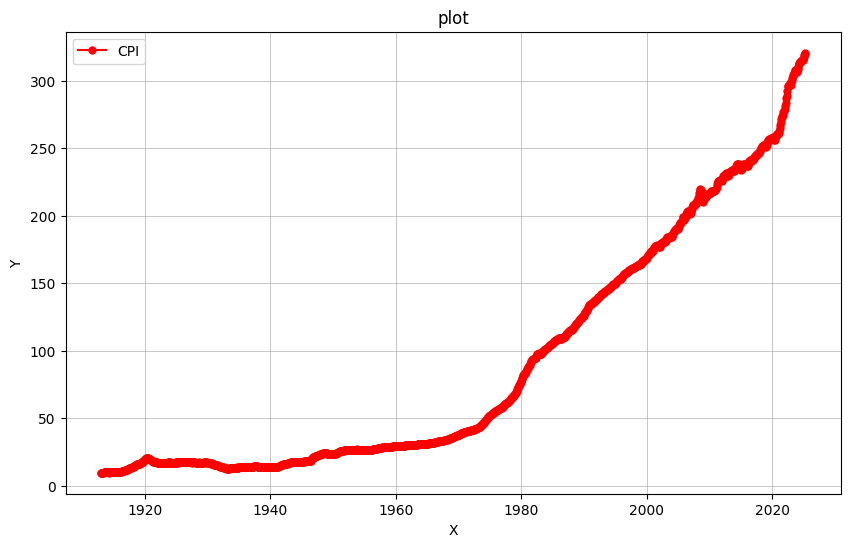

In [89]:
import pandas_datareader.data as web
from datetime import datetime

# SOURCE: https://www.bls.gov/cpi/data.htm
# Start date
start = datetime(1913, 1, 1)

# Download CPI (all goods, month, no season)
cpi = web.DataReader("CPIAUCNS", "fred", start)

# rename
cpi = cpi.rename(columns={"CPIAUCNS": "CPI"})

# turn index into column
cpi = cpi.reset_index()
cpi = cpi.rename(columns={"DATE": "Date"})



dv = DataVisualisation()
print(cpi.head())
cpi_plot = dv.plot_dataframe(cpi,'Date', 'CPI')
cpi_plot.show()

### Read GPR

       month        GPR       GPRH
0 1900-01-01  87.927849  87.927849
1 1900-02-01  86.566490  86.566490
2 1900-03-01  72.140701  72.140701
3 1900-04-01  54.419449  54.419449
4 1900-05-01  64.405197  64.405197


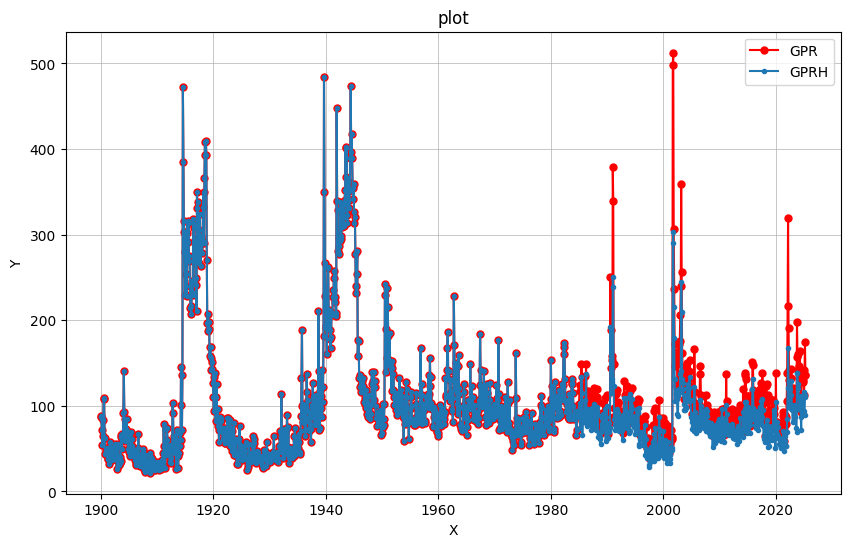

In [100]:
# read xlsx as pandas dataframe
gpr = pd.read_excel(save_path_grp, usecols=[0,1,4])
gpr["GPR"] = gpr["GPR"].fillna(gpr["GPRH"])
print(gpr.head())
dv = DataVisualisation()
gpr_plot = dv.plot_dataframe(gpr,'month', 'GPR',else_y_cols=['GPRH'])
gpr_plot.show()

gpr = gpr[["month","GPR"]]


### Read ETF Holdings (SPDR Gold Shares) data

C:\Users\ieand\AppData\Local\Temp\ipykernel_21672\1988588643.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gld = pd.read_csv(


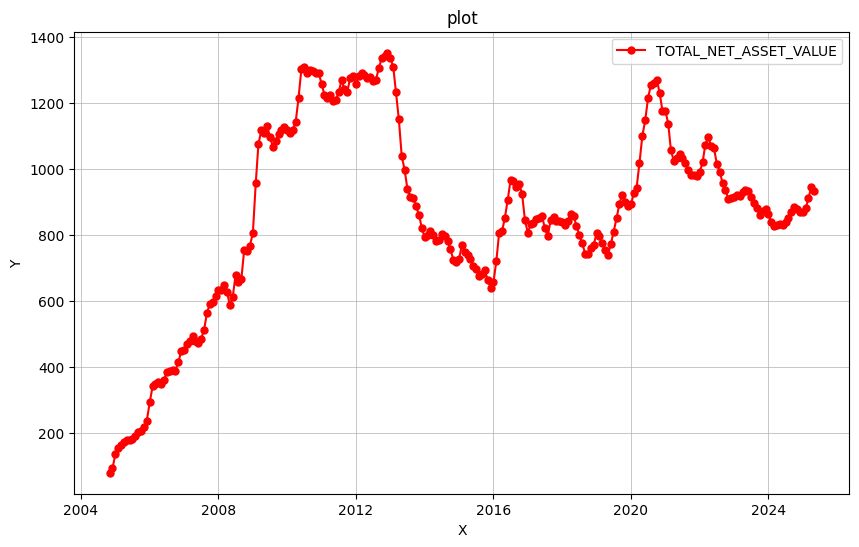

In [91]:
# read csv as pandas dataframe
gld = pd.read_csv(
    save_path_gld,
    parse_dates=["Date"],
    dayfirst=True,
    na_values=["HOLIDAY"]
)

# Remove extra spaces in column headers
gld.columns = gld.columns.str.strip()

# Rename the required column
gld = gld.rename(columns={
    "Total Net Asset Value Tonnes in the Trust as at 4.15 p.m. NYT": "TOTAL_NET_ASSET_VALUE"
})

# Convert the column to numeric type
gld["TOTAL_NET_ASSET_VALUE"] = pd.to_numeric(gld["TOTAL_NET_ASSET_VALUE"], errors="coerce")

# Remove rows with NaN values
gld = gld.dropna(subset=["TOTAL_NET_ASSET_VALUE"])

# Keep only the necessary columns
gld = gld[["Date", "TOTAL_NET_ASSET_VALUE"]]

# Add a month column
gld["Month"] = gld["Date"].dt.to_period("M")

# Calculate the monthly average
monthly_avg = gld.groupby("Month")["TOTAL_NET_ASSET_VALUE"].mean().reset_index()
monthly_avg["Month"] = monthly_avg["Month"].dt.to_timestamp()
gld = monthly_avg
dv = DataVisualisation()

# Plot the data
debt_plot = dv.plot_dataframe(gld, 'Month', 'TOTAL_NET_ASSET_VALUE')
debt_plot.show()

### Read VIX data

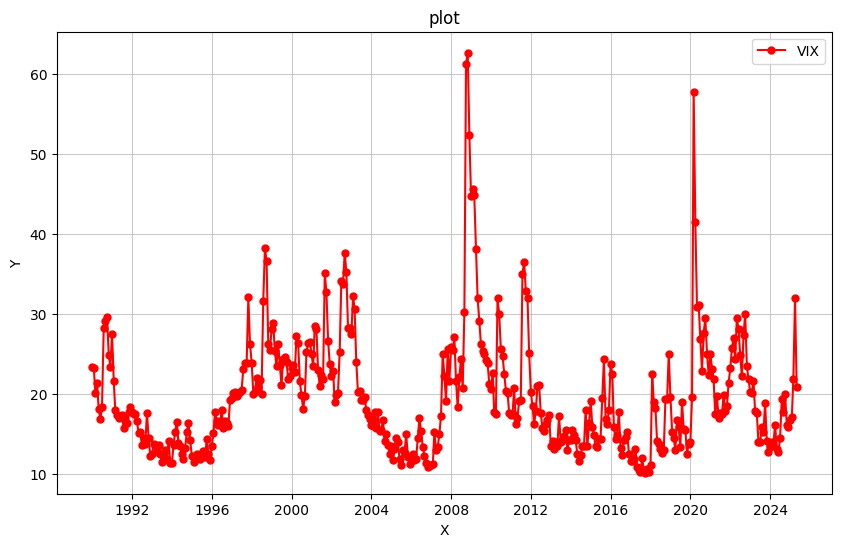

In [92]:

# Step 1: Read CSV
vix = pd.read_csv("data/vix_data.csv")

# Step 2: Clean column names
vix.columns = vix.columns.str.strip()

# Step 3: Rename "Close" column to "VIX"
vix = vix.rename(columns={"Close": "VIX"})

# Step 4: Convert Date to datetime with utc=True, then drop timezone
vix["Date"] = pd.to_datetime(vix["Date"], errors="coerce", utc=True)
vix["Date"] = vix["Date"].dt.tz_convert(None)

# Step 5: Convert VIX to numeric
vix["VIX"] = pd.to_numeric(vix["VIX"], errors="coerce")

# Step 6: Remove rows with missing data
vix = vix.dropna(subset=["Date", "VIX"])

# Step 7: Keep only relevant columns
vix = vix[["Date", "VIX"]]

# Step 8: Add "Month" column and calculate monthly average
vix["Month"] = vix["Date"].dt.to_period("M")
monthly_avg = vix.groupby("Month")["VIX"].mean().reset_index()
monthly_avg["Month"] = monthly_avg["Month"].dt.to_timestamp()
vix = monthly_avg
# Step 9: Plot
dv = DataVisualisation()
vix_plot = dv.plot_dataframe(monthly_avg, 'Month', 'VIX')
vix_plot.show()


### Read dxy data

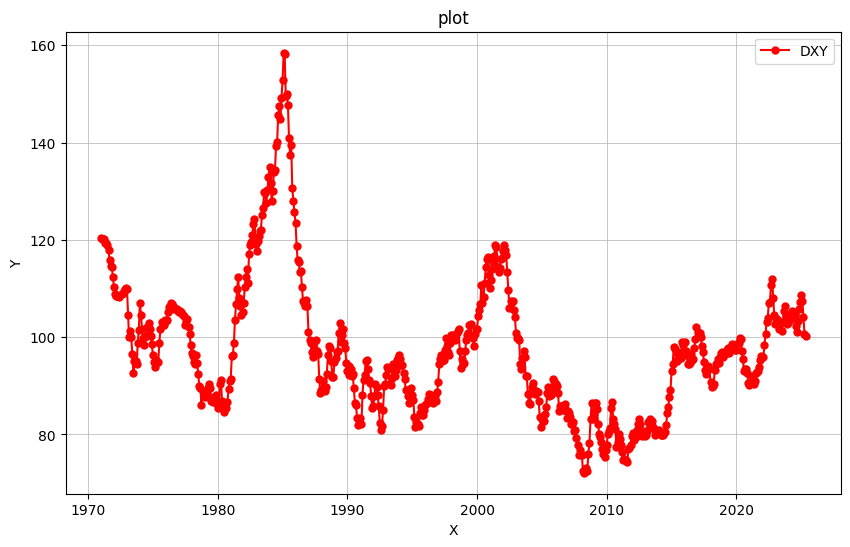

In [93]:

# Step 1: Read CSV
dxy = pd.read_csv("data/dxy_data.csv")

# Step 2: Clean column names
dxy.columns = dxy.columns.str.strip()

# Step 3: Rename "Close" column to "DXY"
dxy = dxy.rename(columns={"Close": "DXY"})

# Step 4: Convert Date to datetime with utc=True, then drop timezone
dxy["Date"] = pd.to_datetime(dxy["Date"], errors="coerce", utc=True)
dxy["Date"] = dxy["Date"].dt.tz_convert(None)

# Step 5: Convert DXY to numeric
dxy["DXY"] = pd.to_numeric(dxy["DXY"], errors="coerce")

# Step 6: Remove rows with missing data
dxy = dxy.dropna(subset=["Date", "DXY"])

# Step 7: Keep only relevant columns
dxy = dxy[["Date", "DXY"]]

# Step 8: Add "Month" column and calculate monthly average
dxy["Month"] = dxy["Date"].dt.to_period("M")
monthly_avg = dxy.groupby("Month")["DXY"].mean().reset_index()
monthly_avg["Month"] = monthly_avg["Month"].dt.to_timestamp()

dxy = monthly_avg

# Step 9: Plot
dv = DataVisualisation()
debt_plot = dv.plot_dataframe(monthly_avg, 'Month', 'DXY')
debt_plot.show()


### Read gold data

          Date     Gold
85  1967-01-01    34.95
86  1967-02-01    34.95
87  1967-03-01    34.95
88  1967-04-01    34.95
89  1967-05-01    34.95
..         ...      ...
780 2024-12-01  2648.01
781 2025-01-01  2709.69
782 2025-02-01  2894.73
783 2025-03-01  2983.25
784 2025-04-01  3217.64

[700 rows x 2 columns]


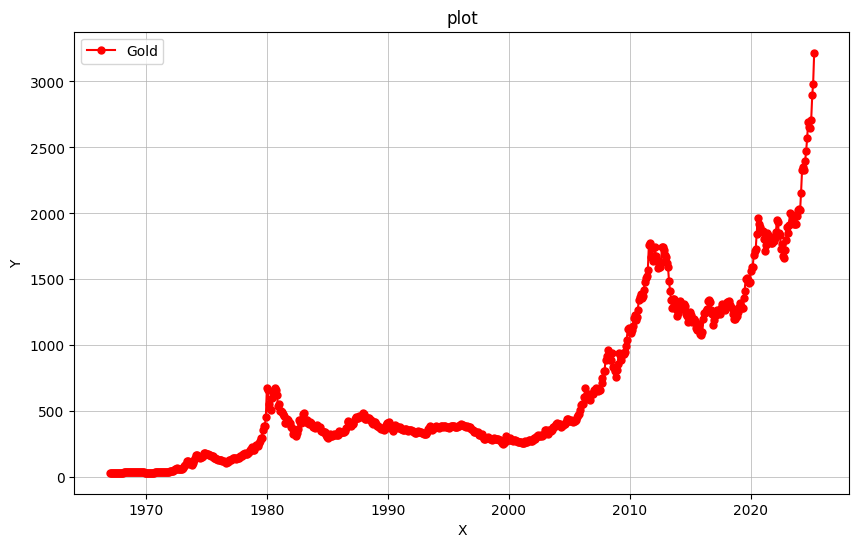

In [102]:

gold = pd.read_excel(
    "data/gold_data.xlsx",
    sheet_name="Monthly Prices",
    skiprows=4 
)

# Rename columns
gold = gold.rename(columns={"Unnamed: 0": "Date"})
gold = gold.rename(columns={"Gold": "Gold"})
gold = gold[['Date','Gold']]
gold = gold.drop(index=0) 
# Convert Date to datetime
gold["Date"] = pd.to_datetime(gold["Date"].str.replace("M", "-") + "-01")

# Filter data from 1967 onward
gold = gold[gold["Date"] >= pd.to_datetime("1967-01-01")]

print(gold)

dv = DataVisualisation()
debt_plot = dv.plot_dataframe(gold, 'Date', 'Gold')
debt_plot.show()

### Read debt data

       Month           Debt
0 1966-01-01  320999.000000
1 1966-02-01  319365.000000
2 1966-03-01  317731.000000
3 1966-04-01  316097.000000
4 1966-05-01  318980.666667


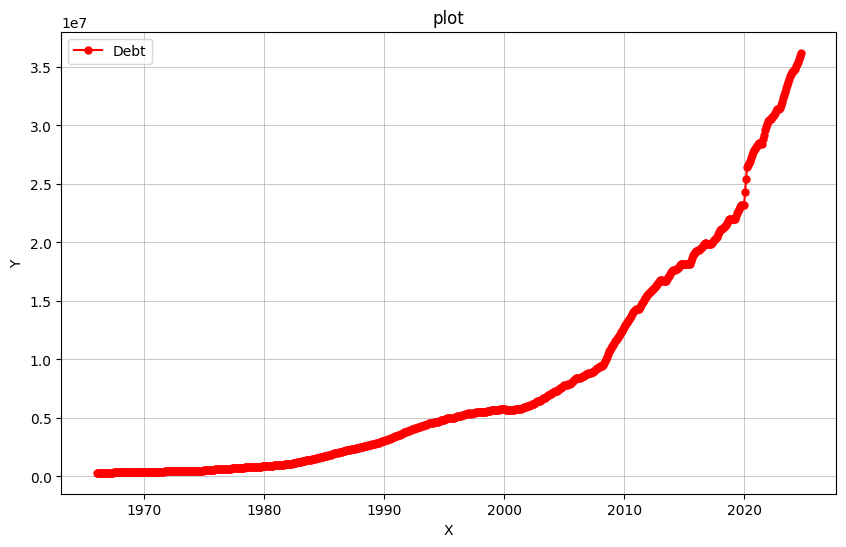

In [95]:
# Step 1: Read CSV
debt = pd.read_csv("data/debt_data.csv")

# Step 2: Clean column names
debt.columns = debt.columns.str.strip()

# Step 3: Rename columns
debt = debt.rename(columns={"observation_date": "Date"})
debt = debt.rename(columns={"GFDEBTN": "Debt"})


# Step 4: Convert Date to datetime with utc=True, then drop timezone
debt["Date"] = pd.to_datetime(debt["Date"], errors="coerce", utc=True)
debt["Date"] = debt["Date"].dt.tz_convert(None)


# Step 8: Add "Month" column and calculate monthly average
debt["Month"] = debt["Date"].dt.to_period("M")
monthly_avg = debt.groupby("Month")["Debt"].mean().reset_index()
monthly_avg["Month"] = monthly_avg["Month"].dt.to_timestamp()
debt = monthly_avg

# Step 9: Create full monthly date range
full_months = pd.date_range(start=debt["Month"].min(), end=debt["Month"].max(), freq='MS')
full_df = pd.DataFrame({"Month": full_months})

# Step 10: Merge with existing data
debt = pd.merge(full_df, debt, on="Month", how="left")

# Step 11: Forward fill to fill missing months with previous quarter value
debt_interpolated = debt
debt_interpolated["Debt"] = debt["Debt"].interpolate(method="linear")
debt["Debt"] = debt["Debt"].ffill()
print(debt_interpolated.head())
# Step 12: Plot again
dv = DataVisualisation()
debt_plot = dv.plot_dataframe(debt_interpolated, 'Month', 'Debt')
debt_plot.show()


### Unite data frames

In [108]:
"""
print(debt.head())
print(gold.head())
print(vix.head())
print(dxy.head())
print(gld.head())
print(gpr.head())
print(cpi.head())
"""
# Step 1: Rename date columns to a common name
debt = debt.rename(columns={"Month": "Date"})
vix = vix.rename(columns={"Month": "Date"})
dxy = dxy.rename(columns={"Month": "Date"})
gld = gld.rename(columns={"Month": "Date"})
gpr = gpr.rename(columns={"month": "Date"})  # already datetime
cpi = cpi.rename(columns={"Date": "Date"})
gold = gold.rename(columns={"Date": "Date"})

# Step 2: Ensure all 'Date' columns are datetime
for df in [debt, vix, dxy, gld, gpr, cpi, gold]:
    df["Date"] = pd.to_datetime(df["Date"], errors='coerce')

# Step 3: Merge all dataframes on the 'Date' column using outer join
merged = debt.copy()
merged = merged.merge(gold, on="Date", how="outer")
merged = merged.merge(vix, on="Date", how="outer")
merged = merged.merge(dxy, on="Date", how="outer")
merged = merged.merge(gld, on="Date", how="outer")
merged = merged.merge(gpr, on="Date", how="outer")
merged = merged.merge(cpi, on="Date", how="outer")

# Step 4: Sort the combined dataframe by date
merged = merged.sort_values("Date").reset_index(drop=True)

# Step 5: Keep only rows where gold price is not NaN
merged = merged[merged["Gold"].notna()].reset_index(drop=True)

print(merged.head())  # Inspect merged result


merged.to_csv("data/merged_filtered_data.csv", index=False)




        Date           Debt   Gold  VIX  DXY  TOTAL_NET_ASSET_VALUE  \
0 1967-01-01  330947.000000  34.95  NaN  NaN                    NaN   
1 1967-02-01  328262.333333  34.95  NaN  NaN                    NaN   
2 1967-03-01  325577.666667  34.95  NaN  NaN                    NaN   
3 1967-04-01  322893.000000  34.95  NaN  NaN                    NaN   
4 1967-05-01  327227.333333  34.95  NaN  NaN                    NaN   

          GPR   CPI  
0   78.875809  32.9  
1   93.530823  32.9  
2  106.475494  33.0  
3   86.284355  33.1  
4  124.016533  33.2  


In [97]:

debt = pd.read_csv("data/HstDebt_17900101_20240930.csv")
debt.columns = ["date","USD_debt"]
debt['date'] = pd.to_datetime(debt['date'])

dv = DataVisualisation()



h_gold_price = pd.read_excel('data/Auronum-Historic-Gold-Price-Data-5.xlsx', usecols=[4,5])
h_gold_price.columns = ["date","USD_gold"]
h_gold_price['date'] = pd.to_datetime(h_gold_price['date'])
h_gold_price.set_index('date', inplace=True)


# Grouping data by year and calculating the average
yearly_avg = h_gold_price.resample('YE').mean()
yearly_avg.reset_index(inplace=True)

# find exponent
y_year = np.array(yearly_avg['USD_gold'])
x_year = np.arange(1, len(y_year)+1)
a,b,c = [52.445,0.0656,98.73] 
exponent_y_year = pi.exponential_func(x_year,a,b,c)

debt['year'] = debt['date'].dt.year
yearly_avg['year'] = yearly_avg['date'].dt.year


merged_df = pd.merge(yearly_avg, debt, on='year')
merged_df['exponent'] = exponent_y_year

a,b,c = [580555710298.038, 0.07217163817885788, -271597937404.2504] #pi.general_least_squares_fit(x_year, np.array(merged_df['USD_debt']), pi.exponential_func,  [580555710298.038, 0.07217163817885788, -271597937404.2504],'exponent', epsilon=1e-6, is_print=True, max_iter=9999)
USD_debt_exponent = pi.exponential_func(x_year,a,b,c)
USD_debt_exponent_deriv = numerical_derivative(lambda xx:pi.exponential_func(xx, a, b, c), x_year)
merged_df['USD_debt_exponent_deriv'] = USD_debt_exponent_deriv
merged_df['USD_debt_exponent'] = USD_debt_exponent
merged_df['USD_debt_exponent_deriv'] = merged_df['USD_debt_exponent_deriv'] / merged_df['USD_debt_exponent_deriv'].max()
merged_df['USD_debt_exponent'] = merged_df['USD_debt_exponent'] / merged_df['USD_debt_exponent'].max()

print(merged_df)
# Normalize
merged_df['USD_gold'] = merged_df['USD_gold'] / merged_df['USD_gold'].max()
merged_df['USD_debt'] = merged_df['USD_debt'] / merged_df['USD_debt'].max()
merged_df['exponent'] = merged_df['exponent'] / merged_df['exponent'].max()



debt_plot = dv.plot_dataframe(merged_df,'year', 'USD_gold',else_y_cols=['USD_debt','exponent','USD_debt_exponent_deriv','USD_debt_exponent'])
debt_plot.show()


FileNotFoundError: [Errno 2] No such file or directory: 'data/HstDebt_17900101_20240930.csv'